In [1]:
import sys
sys.path.append('../scripts/')
from sample_robot import *
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

In [2]:
def sigma_ellipse(p, cov, n): 
    eig_vals, eig_vec = np.linalg.eig(cov)   #共分散行列の固有値を計算
    ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180   #楕円の傾きを計算
    return Ellipse(p, width=n*math.sqrt(eig_vals[0]),height=n*math.sqrt(eig_vals[1]), angle=ang, fill=False, color="blue", alpha=0.5)   #楕円のオブジェクトを作って返す

In [3]:
class KalmanFilter:
    def __init__(self, envmap, init_pose, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.05):
        #ランドマークを観測した時の距離のばらつきの標準偏差が距離に比例した値である時の係数がdistance_dev_rate
        #ランドマークを観測した時の角度のばらつきの標準偏差がdirection_dev 
        self.belief = multivariate_normal(mean=init_pose, \
                                        cov=np.diag([1e-10, 1e-10, 1e-10])) 
        self.motion_noise_stds = motion_noise_stds
        self.map = envmap
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev
    
    #ランドマーク観測後の信念の更新
    def observation_update(self, observation):
        #観測したランドマークの個数だけ繰り返す
        for d in observation:
            z = d[0]
            obs_id = d[1]
            
            #観測値を姿勢xの一次関数に近似する
            #分布の中心でのランドマークの距離と向きに、姿勢xと分布の中心の差に行列Hをかけた値を足して
            #　補正をかけることで、姿勢xからのランドマークの距離と向きを計算する
            ###Hの計算###
            mx, my = self.map.landmarks[obs_id].pos   #観測したランドマークの位置
            mux, muy, mut = self.belief.mean   #分布の中心muのx座標とy座標
            q = (mux - mx)**2 + (muy - my)**2
            sqrtq = np.sqrt(q)   #分布の中心とランドマークの距離
            H = np.array([[(mux - mx)/sqrtq, (muy - my)/sqrtq, 0.0],  [(my - muy)/q, (mux - mx)/q, -1.0]])
            
            ###Qの計算###
            #Qは尤度関数の共分散行列
            #距離と方角を独立と考えているため、対角行列になっている
            hmu = IdealCamera.relative_polar_pos(self.belief.mean, self.map.landmarks[obs_id].pos)
            distance_dev = self.distance_dev_rate*hmu[0]
            Q = np.diag(np.array([distance_dev**2, self.direction_dev**2]))
            
            ###カルマンゲインの計算###
            K = self.belief.cov.dot(H.T).dot(np.linalg.inv(Q + H.dot(self.belief.cov).dot(H.T)))
            
            ###更新###
            #分布の中心の更新、ランドマークの計測値を信念に反映した
            #計測値zと分布の中心から見たランドマークの距離と方角hmuの差にカルマンゲインをかけた値で分布の中心を更新
            self.belief.mean += K.dot(z - hmu)
            #共分散行列の更新
            self.belief.cov = (np.eye(3) - K.dot(H)).dot(self.belief.cov)
        
    #速度、角速度の指令値と雑音から信念分布の遷移を行う
    def motion_update(self, nu, omega, time):
        if abs(omega) < 1e-5: omega = 1e-5 #ゼロにすると式が変わるので避ける
        if abs(nu) < 1e-5:         nu = 1e-5
            
        #ロボットが速度、角速度を指令された時、実際に出力する速度、角速度について雑音モデルをガウス分布で表した際の共分散行列がM_t
        v = self.motion_noise_stds
        M = np.diag([v["nn"]**2*abs(nu)/time + v["no"]**2*abs(omega)/time,    #共分散行列 M_t の計算
                     v["on"]**2*abs(nu)/time + v["oo"]**2*abs(omega)/time])
        
        t = self.belief.mean[2]   #θの平均値
        st, ct = math.sin(t), math.cos(t)   #sin(θ),cos(θ)
        stw, ctw = math.sin(t + omega*time), math.cos(t + omega*time)   #sin(θ+wt),cos(θ+wt)
        #nuomega空間のガウス分布をxyθ空間のガウス分布に近似的に変換するために線形化を行う、その際に使う行列がA_t
        #A_tは制御入力が指令値からずれた量に比例して、姿勢xをどれだけずらすかを決める行列
        A = np.array([[(stw - st)/omega,    -nu/(omega**2)*(stw - st) + nu/omega*time*ctw],   #A_t を計算　xyθ空間での雑音の蓄積を表す式から誤差のベクトルを除いたもの
                                 [(-ctw + ct)/omega, -nu/(omega**2)*(-ctw + ct) + nu/omega*time*stw],
                                 [0,                                time]] )
        
        #F を計算、信念分布の遷移を計算するのに使うもの
        #状態遷移関数fを線形化する際に出てきた
        #移動する前の分布の中心mu_t-1付近でfが姿勢xの変化に対してどれだけの割合で変化するかを求めた行列
        F = np.diag([1.0, 1.0, 1.0])
        F[0, 2] = nu / omega * (math.cos(t + omega * time) - math.cos(t))
        F[1, 2] = nu / omega * (math.sin(t + omega * time) - math.sin(t))
        
        #ロボット移動後の信念の共分散行列
        self.belief.cov = F.dot(self.belief.cov).dot(F.T) + A.dot(M).dot(A.T)   #A.dot(M).dot(A.T) は R_t
        #ロボット移動後の信念の中心
        self.belief.mean = IdealRobot.state_transition(nu, omega, time, self.belief.mean)
        
    def draw(self, ax, elems):
        ###xy平面上の誤差の3シグマ範囲###
        #誤差楕円の描画、3つ目の引数がシグマ範囲を決めている、3なら３シグマ範囲、大きい値だと誤差楕円が大きくなる
        e = sigma_ellipse(self.belief.mean[0:2], self.belief.cov[0:2, 0:2], 3)   #共分散行列から右上の2x2（xとyにかんするもの）を取り出してsigma_ellipseに与える
        elems.append(ax.add_patch(e))

        ###θ方向の誤差の3シグマ範囲###
        x, y, c = self.belief.mean   #平均値を計算
        #θ方向の誤差の描画、最後にかけている値でシグマ範囲が決まる、3なら3シグマ範囲、大きい値だとθの誤差を表す線分の開き角度が大きくなる
        sigma3 = math.sqrt(self.belief.cov[2, 2])*3
        xs = [x + math.cos(c-sigma3), x, x + math.cos(c+sigma3)]   #x方向
        ys = [y + math.sin(c-sigma3), y, y + math.sin(c+sigma3)]   #y方向
        elems += ax.plot(xs, ys, color="blue", alpha=0.5)

In [4]:
class KfAgent(Agent): 
    def __init__(self, time_interval, nu, omega, init_pose, envmap, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):   #雑音を決定するパラメータ
                #nn は直進1[m]あたりに生じる直進方向のばらつきの標準偏差
                #no は回転1[rad]あたりに生じる直進方向のばらつきの標準偏差
                #on は直進1[m]あたりに生じる回転方向のばらつきの標準偏差
                #oo は回転1[rad]あたりに生じる回転方向のばらつきの標準偏差
        super().__init__(nu, omega)
        self.kf = KalmanFilter(envmap, init_pose, motion_noise_stds) 
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None):
        self.kf.motion_update(self.prev_nu, self.prev_omega, self.time_interval) 
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.kf.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.kf.draw(ax, elems)

<IPython.core.display.Javascript object>


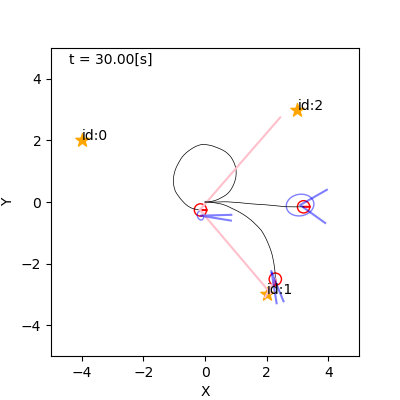

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1   #姿勢を更新する時間間隔であるΔtに相当するもの、また描画する時間間隔、0.1なら0.1秒ごとに描画する
    world = World(30, time_interval) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))   #ランドマークの座標を指定
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    #円軌道を描くロボット
    #KfAgent 2つ目の引数が速度[m/s]、3つ目の引数が角速度[deg/s]、4つ目の引数は初期位置、5つ目の引数で地図を渡す　計測値と地図中のランドマーク位置を比較するため
    circling = KfAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T, m)
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=circling, color="red")
    world.append(r)
    #直線軌道を描くロボット
    linear = KfAgent(time_interval, 0.1, 0.0, np.array([0, 0, 0]).T, m)
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=linear, color="red")
    world.append(r)
    #右に曲がる軌道を描くロボット
    right = KfAgent(time_interval, 0.1, -3.0/180*math.pi, np.array([0, 0, 0]).T, m)
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=right, color="red")
    world.append(r)

    world.draw()                       # アニメーションさせるとき
   # r.one_step(time_interval)  # アニメーションなしでデバッグするとき